In [1]:
import pandas as pd
import numpy as np
import statistics

# this code calls tensorflow 1 compatibility
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import seaborn as sns
from BasicAutoencoder import DeepAE as DAE
from shrink import l21shrink as SHR  # also changing to l1 to access function
import xlrd
from RobustDeepAutoencoder import RDAE 
import numpy.linalg as nplin
import matplotlib.pyplot as plt

print("TensorFlow Version:", tf.__version__) 
# doesn't matter that tf is 2.3 because gen 1 compatibility is specified. 

Instructions for updating:
non-resource variables are not supported in the long term
TensorFlow Version: 2.2.0


# Terms:

Inner iteration:
    
Outer iteration:

In [35]:
class RDAE(object):
    """
    @author: Chong Zhou
    2.0 version.
    complete: 10/17/2016
    version changes: move implementation from theano to tensorflow.
    3.0
    complete: 2/12/2018
    changes: delete unused parameter, move shrink function to other file
    update: 03/15/2019
        update to python3 
    Des:
        X = L + S
        L is a non-linearly low rank matrix and S is a sparse matrix.
        argmin ||L - Decoder(Encoder(L))|| + ||S||_1
        Use Alternating projection to train model
    """
    def __init__(self, sess, layers_sizes, lambda_=1.0, error = 1.0e-7):
        """
        sess: a Tensorflow tf.Session object
        layers_sizes: a list that contain the deep ae layer sizes, including the input layer
        lambda_: tuning the weight of l1 penalty of S
        error: converge criterior for jump out training iteration
        """
        self.lambda_ = lambda_
        self.layers_sizes = layers_sizes
        self.error = error
        self.errors=[]
        
        # made changes to deep AE so encoder only takes 1 row as input, will likely break this.. 
        self.AE = DAE.Deep_Autoencoder( sess = sess, input_dim_list = self.layers_sizes)

    def fit(self, X, sess, learning_rate=0.15, inner_iteration = X.shape[0],
            iteration=1, batch_size=1, verbose=False):
        
        ## The first layer must be the input layer, so they should have same sizes.
        assert type(X) == np.matrix, "Data must be a numpy matrix."
        assert X.shape[1] == self.layers_sizes[0], "The number of columns should match the first layer."
        
        ## initialize L, S, mu(shrinkage operator)
        ### could try setting array of zeros equal to the number of columns... # changing from X.shape to X.shape[1]
        self.L = np.zeros(X.shape[1])
        self.S = np.zeros(X.shape[1])

        print("L shape:", self.L.shape) # L is 141 x 20; need to treat each row as it's own element. 
        
        print("X size is:", X.size, "(in case it requires adjusting too)")
        
        # X.size: .size is a np function that counts all elements in a matrix (np array) along the specified axis.
        # if no axis is specified, counts all elements in the matrix.
        mu = (X.size) / (4.0 * nplin.norm(X,1))
        print ("shrink parameter:", self.lambda_ / mu)
        LS0 = self.L + self.S

        XFnorm = nplin.norm(X,'fro')
        if verbose:
            print ("X shape: ", X.shape)
            print ("L shape: ", self.L.shape)
            print ("S shape: ", self.S.shape)
            print ("mu: ", mu)
            print ("XFnorm: ", XFnorm)

        for it in range(iteration):
            if verbose:
                print ("Out iteration: " , it)
            ## alternating project, first project to L
            self.L = X - self.S
            
            ## Using L to train the auto-encoder
            self.AE.fit(X = self.L, sess = sess,
                                    iteration = inner_iteration,
                                    learning_rate = learning_rate,
                                    batch_size = batch_size,
                                    verbose = verbose)
            
            ## get optmized L
            self.L = self.AE.getRecon(X = self.L, sess = sess)
            
            ## alternating project, now project to S
            ### *changed SHR.shrink to l21shrink * ###
            ### * should we be using l21 shrink? ### --> check paper... 
            self.S = SHR.l21shrink(self.lambda_/mu, (X - self.L).reshape(X.size)).reshape(X.shape)

            ## break criterion 1: the L and S are close enough to X
            c1 = nplin.norm(X - self.L - self.S, 'fro') / XFnorm
            
            ## break criterion 2: there is no changes for L and S 
            c2 = np.min([mu,np.sqrt(mu)]) * nplin.norm(LS0 - self.L - self.S) / XFnorm

            if verbose:
                print ("Break Criterion 1: the L and S are close enough to X", c1)
                print ("Break Criterion 2: there is no changes for L and S", c2)

            if c1 < self.error and c2 < self.error :
                print ("early break")
                break
                
            ## save L + S for c2 check in the next iteration
            LS0 = self.L + self.S
            
        return self.L , self.S
    
    def transform(self, X, sess):
        L = X - self.S
        return self.AE.transform(X = L, sess = sess)
    
    def getRecon(self, X, sess):
        return self.AE.getRecon(X, sess = sess)

### Create a matrix of Sine,  Cosine, & Tangent data to evaluate workflow

In [159]:
import numpy as np
pi_vals = np.linspace(-np.pi, np.pi, 100)
sin = np.sin(pi_vals)
cos = np.cos(pi_vals)
tan = np.tan(pi_vals)

X = np.array([])
pi_dev = np.std(abs(pi_vals))/1000

n = 50
corruption_rate = 0.02
for i in range(0,n):
    # create noise arrays (don't want to be repeating the exact same noise patterns across columns)
    noise1 = np.random.normal(0,pi_dev, 100)
    noise2 = np.random.normal(0,pi_dev, 100)
    noise3 = np.random.normal(0,pi_dev, 100)
    
    # Combine signal and noise
    sin_noise = sin + noise1
    cos_noise = cos + noise2
    tan_noise = tan + noise3
    
    # Corrupt 
    sin_cor = sin + np.random.binomial(1, corruption_rate, 100) * sin_noise
    cos_cor = cos + np.random.binomial(1, corruption_rate, 100) * cos_noise
    tan_cor = tan + np.random.binomial(1, corruption_rate, 100) * tan_noise
    
    X = np.append(X, sin_cor)
    X = np.append(X, cos_cor)
    #X = np.append(X, tan_cor)

X = np.reshape(X, newshape = (100, 100))
X = X.T

### Plot data to visualize

Text(0.5, 1.0, 'Example of Corrupted Sine Data')

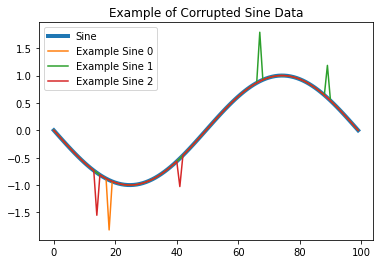

In [165]:
sine = np.array([])
for i in range(0,n):
    noise1 = np.random.normal(0,pi_dev, 100)
    sin_noise = sin + noise1
    sin_cor = sin + np.random.binomial(1, corruption_rate, 100) * sin_noise
    sine = np.append(sine, sin_cor)
    
sine = np.reshape(sine, newshape = (50, 100))
sine = sine.T

plt.plot(sin, label = 'Sine', linewidth = 4)
for i in range(0, 3):
    plt.plot(sine[:,i], label = f'Example Sine {i}')
plt.legend()
plt.title("Example of Corrupted Sine Data")

In [166]:
# X is a data frame containing corrupted Sine, Cosine, and Tangent data
# 100 rows of 150 columns, where each column represents 1 of the wave functions
print(X.shape)

(100, 100)


### Normalize

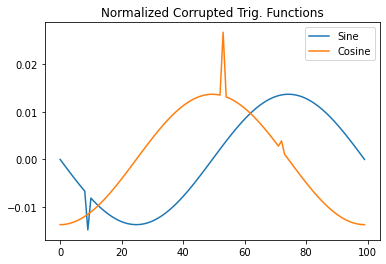

In [167]:
labs = ['Sine', 'Cosine', 'Tangent']
X = X/np.linalg.norm(X)
for i in range(0,2):
    l = labs[i]
    plt.plot(X[:,i], label = f'{l}')
plt.title("Normalized Corrupted Trig. Functions")
plt.legend()

# Initialize Model

### Training at varying levels of lambda: 
Lambda = min(cost)
1.0 = 0.52
0.5 = 0.06
0.2 = 0.014
0.10 = 0.0034669712
0.01 = 5x10^-0.5
0.00065 = 0.0003
0.00005 = 1.1x10^-6
0.000015 = 2.1x10^-7 # this parameter should be close enough; achieved 1.17x10^-10
0.000005 = 0.002

### Train numbers matrix

In [ ]:
### I think the big issue here is I need to understant the following: 
# What's being fed in (keep column-wise rows?)
# What do the iterations need to be set to within the RDAE? 
# 

In [168]:
r, c = X.shape
r
c


100

In [65]:
a = 'str'
assert type(X) == np.matrix, "Data must be a numpy matrix."
#assert X is np

AssertionError: Data must be a numpy matrix.

L shape: (100,)
X size is: 10000 (in case it requires adjusting too)
shrink parameter: 0.013534702538626622
X shape:  (100, 100)
L shape:  (100,)
S shape:  (100,)
mu:  2659.829419764474
XFnorm:  1.0
Out iteration:  0
    iteration :  0 , cost :  0.020023478
Break Criterion 1: the L and S are close enough to X 0.9718847387411006
Break Criterion 2: there is no changes for L and S 6.392532331481356
Out iteration:  1
    iteration :  0 , cost :  0.018890664
Break Criterion 1: the L and S are close enough to X 0.9724800499392605
Break Criterion 2: there is no changes for L and S 0.4411886412530749
Out iteration:  2
    iteration :  0 , cost :  0.018914115
Break Criterion 1: the L and S are close enough to X 0.9727136903732791
Break Criterion 2: there is no changes for L and S 0.2696108489260011
Out iteration:  3
    iteration :  0 , cost :  0.01892331
Break Criterion 1: the L and S are close enough to X 0.9727996425910986
Break Criterion 2: there is no changes for L and S 0.2168793320270649

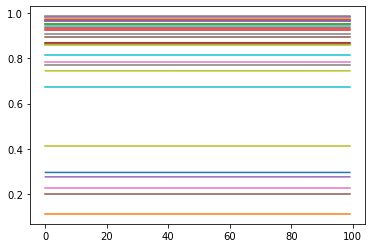

In [528]:
class RDAE(object):
    """
    @author: Chong Zhou
    2.0 version.
    complete: 10/17/2016
    version changes: move implementation from theano to tensorflow.
    3.0
    complete: 2/12/2018
    changes: delete unused parameter, move shrink function to other file
    update: 03/15/2019
        update to python3 
    Des:
        X = L + S
        L is a non-linearly low rank matrix and S is a sparse matrix.
        argmin ||L - Decoder(Encoder(L))|| + ||S||_1
        Use Alternating projection to train model
    """
    def __init__(self, sess, layers_sizes, lambda_=1.0, error = 1.0e-7):
        """
        sess: a Tensorflow tf.Session object
        layers_sizes: a list that contain the deep ae layer sizes, including the input layer
        lambda_: tuning the weight of l1 penalty of S
        error: converge criterior for jump out training iteration
        """
        self.lambda_ = lambda_
        self.layers_sizes = layers_sizes
        self.error = error
        self.errors=[]
        
        # made changes to deep AE so encoder only takes 1 row as input, will likely break this.. 
        self.AE = DAE.Deep_Autoencoder( sess = sess, input_dim_list = self.layers_sizes)

    def fit(self, X, sess, learning_rate=0.15, inner_iteration = X.shape[0],
            iteration=1, batch_size=1, verbose=False):
        
        ## The first layer must be the input layer, so they should have same sizes.
        assert type(X) == np.matrix, "Data must be a numpy matrix."
        assert X.shape[1] == self.layers_sizes[0], "The number of columns should match the first layer."
        
        ## initialize L, S, mu(shrinkage operator)
        ### could try setting array of zeros equal to the number of columns... # changing from X.shape to X.shape[1]
        self.L = np.zeros(X.shape[1])
        self.S = np.zeros(X.shape[1])

        print("L shape:", self.L.shape) # L is 141 x 20; need to treat each row as it's own element. 
        
        print("X size is:", X.size, "(in case it requires adjusting too)")
        
        # X.size: .size is a np function that counts all elements in a matrix (np array) along the specified axis.
        # if no axis is specified, counts all elements in the matrix.
        mu = (X.size) / (4.0 * nplin.norm(X,1))
        print ("shrink parameter:", self.lambda_ / mu)
        LS0 = self.L + self.S

        XFnorm = nplin.norm(X,'fro')
        if verbose:
            print ("X shape: ", X.shape)
            print ("L shape: ", self.L.shape)
            print ("S shape: ", self.S.shape)
            print ("mu: ", mu)
            print ("XFnorm: ", XFnorm)

        for it in range(iteration):
            if verbose:
                print ("Out iteration: " , it)
            ## alternating project, first project to L
            self.L = X - self.S
            
            ## Using L to train the auto-encoder
            self.AE.fit(X = self.L, sess = sess,
                                    iteration = inner_iteration,
                                    learning_rate = learning_rate,
                                    batch_size = batch_size,
                                    verbose = verbose)
            
            ## get optmized L
            self.L = self.AE.getRecon(X = self.L, sess = sess)
            
            ## alternating project, now project to S
            ### *changed SHR.shrink to l21shrink * ###
            ### * should we be using l21 shrink? ### --> check paper... 
            self.S = SHR.l21shrink(self.lambda_/mu, (X - self.L).reshape(X.size)).reshape(X.shape)

            ## break criterion 1: the L and S are close enough to X
            c1 = nplin.norm(X - self.L - self.S, 'fro') / XFnorm
            
            ## break criterion 2: there is no changes for L and S 
            c2 = np.min([mu,np.sqrt(mu)]) * nplin.norm(LS0 - self.L - self.S) / XFnorm

            if verbose:
                print ("Break Criterion 1: the L and S are close enough to X", c1)
                print ("Break Criterion 2: there is no changes for L and S", c2)

            if c1 < self.error and c2 < self.error :
                print ("early break")
                break
                
            ## save L + S for c2 check in the next iteration
            LS0 = self.L + self.S
            
        return self.L , self.S
    
    def transform(self, X, sess):
        L = X - self.S
        return self.AE.transform(X = L, sess = sess)
    
    def getRecon(self, X, sess):
        return self.AE.getRecon(X, sess = sess)


# Original 
if __name__ == "__main__":
    #x = np.load(r"../data/data.npk", allow_pickle = True)[:500]
    
    # X must be a matrix! add assert in rae.fit
    X = np.matrix(X)
    
    # transpose so that each 'gene' is a row and each 'sample' is a column
    # as described in the boosting paper, where X = {x sub ij} where xij stands for an 
    # expression level of gene i from sample j at a specific time point or in a specific condition.
    #X = X.T
    # based on our inputs, each column should be a gene. 
    
    
    with tf.Session() as sess:
        r, c = X.shape
        
        # at lambda of 5 we start to get more interesting L values
        # at lambda of 10 vals are similarly square and blocky
        # at labmda of 20 there is more curvature introduced to the system
        # continues at lambda of 30, S is starting to look goofy. parts are identifiable with the 
        # original signal
        # 40 values looking even better... 
        ### 35 seems like it's pretty close to optimal ###
        
        # Only specify encoder layer, the decoder uses encoder layers in reverse
        layers = [c, round(c * 0.9), round(c * 0.8), round(c * 0.7), round(c * 0.6), round(c * 0.3)]
        rae = RDAE(sess = sess, lambda_= 36, layers_sizes= layers) 
        # , 5, 10, 20 # [784,400,255,100]
        # lr was default 0.15
        L, S = rae.fit(X, sess = sess, learning_rate=0.01, inner_iteration = round(X.shape[0]/5),\
                       iteration = 5,verbose = True) 
        l21R = rae.getRecon(X, sess = sess)
        l21H = rae.transform(X, sess)
        
        # double check the author's implementation... 
        
        # lambda is the balancing parameter that tunes sparsity
        # adding these two to the model
        #M_Transf=rae.transform(X=X,sess=sess)
        #M_Recons = rae.getRecon(X = X, sess = sess)        
        
# probably need to read the paper! OG paper from Chou
# lambda of ~10 was working okay for S and X but not enough signal was getting into L
print("l21H shape:", l21H.shape)

# need to understand l21H shape... 
# RAE transform.. 
for i in range(l21H.shape[1]):
    plt.plot(l21H[:,i])

l21H shape: (100, 30)


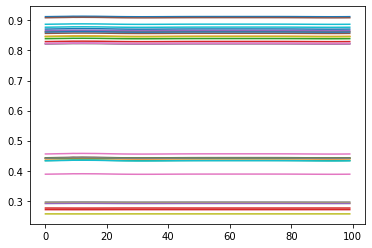

In [523]:
#l21H = l21H.T
print("l21H shape:", l21H.shape)
for i in range(l21H.shape[1]):
    plt.plot(l21H[:,i])

np.mean(l21H, axis = 0).shape

In [501]:
# Reconstruction
print("l21R shape:", l21R.shape)
for i in range(l21R.shape[1]):
    #plt.plot(l21R[:,i])
    if np.mean(l21R[:,i]) > 0.5:
        plt.plot(l21R[:,i])

l21R shape: (100, 100)


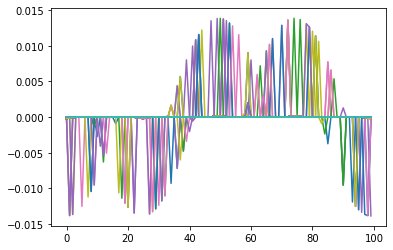

In [487]:
for i in range(S.shape[1]):
    plt.plot(S[:,i], label = "S val")
    plt.plot(L[:,i], label = "L val")
    #plt.plot(X[:,i], label = "X val")

l21H shape: (100, 85)


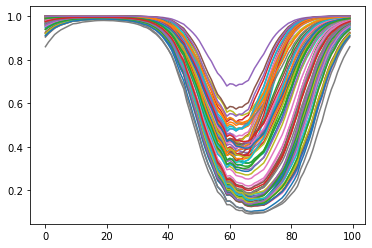

In [488]:
# L21H Is L minus S, our denoised data!
print("l21H shape:", l21H.shape)
for i in range(l21H.shape[1]):
    plt.plot(l21H[:,i])

(array([50.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 50.]),
 array([-1.37060042e-02, -1.23344081e-02, -1.09628121e-02, -9.59121602e-03,
        -8.21961997e-03, -6.84802393e-03, -5.47642788e-03, -4.10483183e-03,
        -2.73323579e-03, -1.36163974e-03,  9.95630713e-06]),
 <a list of 10 Patch objects>)

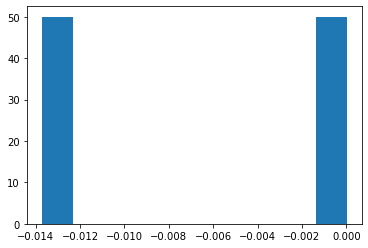

In [498]:
# plot A as hist, should get two clusters
a = X[0,:].reshape(-1,1)
plt.hist(a)

l21H Reconstruction Shape: (100, 50)
single signal shape: (100,)
l21R Transformation Shape: (100, 100)


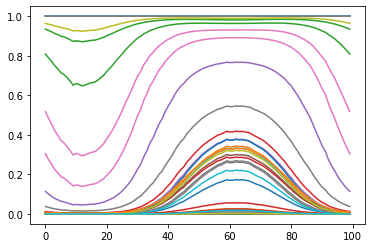

In [408]:
# lambda of ~10 was working okay for S and X but not enough signal was getting into L
print("l21H Reconstruction Shape:", l21H.shape) # low level embeddings
print("single signal shape:", l21H[:,0].shape)
# 100 rows and 100 columns is compressed to 100 rows and 50 columns... 
# what... each signal still has 100 values, but there are only 50 signals... 

# l21H should at least be able to clearly separate the two groups

print("l21R Transformation Shape:", l21R.shape)

for i in range(l21H.shape[1]):
    plt.plot(l21H[:,i], label = "S val")
    #plt.plot(L[:,i], label = "L val")
    #plt.plot(X[:,i], label = "X val")

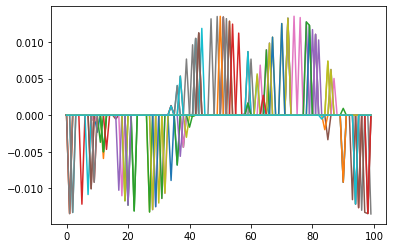

In [413]:
# check that 'S' contains the noise. Yep. 
for i in range(S.shape[1]):
    plt.plot(S[:,i], label = "S val")


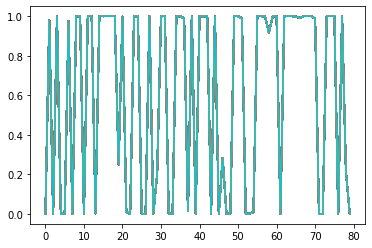

In [291]:
for i in range(l21H.shape[0]):
    plt.plot(l21H[i,:], label = "L val")

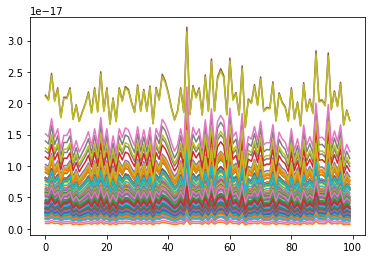

In [287]:
for i in range(l21R.shape[0]):
    plt.plot(l21R[:, i], label = "L val")

In [262]:
## Converting probe ID to gene
path = "C:/Users/user/Documents/CDA/RDAE/"
file = "Leukemia_GSE22529_U133B.csv"

# Gene Expression Data
cll = pd.read_csv(path + file)
print(len(cll.columns[2:]))

# write to txt file:
probe_ids = cll.columns[2:]
new_file_name = path + "cll_probe_ids.txt"
f = open(new_file_name, "x")
f.write(probe_ids)

22645


TypeError: write() argument must be str, not Index

In [272]:
probe_ids = [str(i) for i in probe_ids]
probe_ids

new_file_name = path + "cll_probe_ids.txt"
f = open(new_file_name, "x")
f.write(str(probe_ids))
f.close()
#str(cll.columns[2:].values)

FileExistsError: [Errno 17] File exists: 'C:/Users/user/Documents/CDA/RDAE/cll_probe_ids.txt'

In [281]:
# RAE getRecon: 
# write to txt file:
probe_ids = cll.columns[2:]
probe_ids = ', '.join([str(i) for i in probe_ids])
print(probe_ids[0:10])

new_file_name = path + "cll_probe_ids.txt"
f = open(new_file_name, "x")
f.write(str(probe_ids))
f.close()

#f.close()

200000_s_a


In [280]:
### Grid search for param values
f.close()

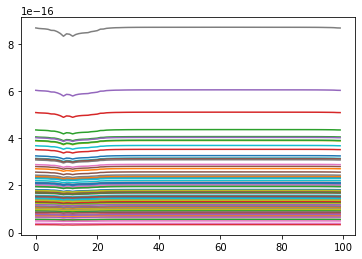

In [254]:
for i in range(l21R.shape[1]):
    plt.plot(l21R[:,i], label = "L val")

In [ ]:
for i in range(X.shape[1]):
    plt.plot(X[:,i], label = "L val")

L shape: (100,)
X size is: 10000 (in case it requires adjusting too)
shrink parameter: 0.07459507338705801
X shape:  (100, 100)
L shape:  (100,)
S shape:  (100,)
mu:  2681.142211124888
XFnorm:  1.0
Out iteration:  0
    iteration :  0 , cost :  0.020000014
    iteration :  20 , cost :  0.020000014
    iteration :  40 , cost :  0.020000014
    iteration :  60 , cost :  0.020000014
    iteration :  80 , cost :  0.020000014
Break Criterion 1: the L and S are close enough to X 1.0
Break Criterion 2: there is no changes for L and S 1.1967974670272484e-15
Out iteration:  1
    iteration :  0 , cost :  0.020000014
    iteration :  20 , cost :  0.020000014
    iteration :  40 , cost :  0.020000014
    iteration :  60 , cost :  0.020000014
    iteration :  80 , cost :  0.020000014
Break Criterion 1: the L and S are close enough to X 1.0
Break Criterion 2: there is no changes for L and S 0.0
Out iteration:  2
    iteration :  0 , cost :  0.020000014
    iteration :  20 , cost :  0.020000014
    

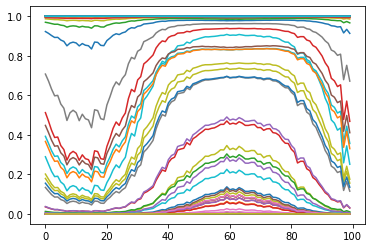

In [122]:
class RDAE(object):
    """
    @author: Chong Zhou
    2.0 version.
    complete: 10/17/2016
    version changes: move implementation from theano to tensorflow.
    3.0
    complete: 2/12/2018
    changes: delete unused parameter, move shrink function to other file
    update: 03/15/2019
        update to python3 
    Des:
        X = L + S
        L is a non-linearly low rank matrix and S is a sparse matrix.
        argmin ||L - Decoder(Encoder(L))|| + ||S||_1
        Use Alternating projection to train model
    """
    def __init__(self, sess, layers_sizes, lambda_=1.0, error = 1.0e-7):
        """
        sess: a Tensorflow tf.Session object
        layers_sizes: a list that contain the deep ae layer sizes, including the input layer
        lambda_: tuning the weight of l1 penalty of S
        error: converge criterior for jump out training iteration
        """
        self.lambda_ = lambda_
        self.layers_sizes = layers_sizes
        self.error = error
        self.errors=[]
        
        # made changes to deep AE so encoder only takes 1 row as input, will likely break this.. 
        self.AE = DAE.Deep_Autoencoder( sess = sess, input_dim_list = self.layers_sizes)

    def fit(self, X, sess, learning_rate=0.15, inner_iteration = X.shape[0],
            iteration=1, batch_size=1, verbose=False):
        
        ## The first layer must be the input layer, so they should have same sizes.
        assert type(X) == np.matrix, "Data must be a numpy matrix."
        assert X.shape[1] == self.layers_sizes[0], "The number of columns should match the first layer."
        
        ## initialize L, S, mu(shrinkage operator)
        ### could try setting array of zeros equal to the number of columns... # changing from X.shape to X.shape[1]
        self.L = np.zeros(X.shape[1])
        self.S = np.zeros(X.shape[1])

        print("L shape:", self.L.shape) # L is 141 x 20; need to treat each row as it's own element. 
        
        print("X size is:", X.size, "(in case it requires adjusting too)")
        
        # X.size: .size is a np function that counts all elements in a matrix (np array) along the specified axis.
        # if no axis is specified, counts all elements in the matrix.
        mu = (X.size) / (4.0 * nplin.norm(X,1))
        print ("shrink parameter:", self.lambda_ / mu)
        LS0 = self.L + self.S

        XFnorm = nplin.norm(X,'fro')
        if verbose:
            print ("X shape: ", X.shape)
            print ("L shape: ", self.L.shape)
            print ("S shape: ", self.S.shape)
            print ("mu: ", mu)
            print ("XFnorm: ", XFnorm)

        for it in range(iteration):
            if verbose:
                print ("Out iteration: " , it)
            ## alternating project, first project to L
            self.L = X - self.S
            
            ## Using L to train the auto-encoder
            self.AE.fit(X = self.L, sess = sess,
                                    iteration = inner_iteration,
                                    learning_rate = learning_rate,
                                    batch_size = batch_size,
                                    verbose = verbose)
            
            ## get optmized L
            self.L = self.AE.getRecon(X = self.L, sess = sess)
            
            ## alternating project, now project to S
            ### *changed SHR.shrink to l21shrink * ###
            ### * should we be using l21 shrink? ### --> check paper... 
            self.S = SHR.l21shrink(self.lambda_/mu, (X - self.L).reshape(X.size)).reshape(X.shape)

            ## break criterion 1: the L and S are close enough to X
            c1 = nplin.norm(X - self.L - self.S, 'fro') / XFnorm
            
            ## break criterion 2: there is no changes for L and S 
            c2 = np.min([mu,np.sqrt(mu)]) * nplin.norm(LS0 - self.L - self.S) / XFnorm

            if verbose:
                print ("Break Criterion 1: the L and S are close enough to X", c1)
                print ("Break Criterion 2: there is no changes for L and S", c2)

            if c1 < self.error and c2 < self.error :
                print ("early break")
                break
                
            ## save L + S for c2 check in the next iteration
            LS0 = self.L + self.S
            
        return self.L , self.S
    
    def transform(self, X, sess):
        L = X - self.S
        return self.AE.transform(X = L, sess = sess)
    
    def getRecon(self, X, sess):
        return self.AE.getRecon(X, sess = sess)


# Original 
if __name__ == "__main__":
    #x = np.load(r"../data/data.npk", allow_pickle = True)[:500]
    
    # X must be a matrix! add assert in rae.fit
    X = np.matrix(X)
    
    with tf.Session() as sess:
        r, c = X.shape
        rae = RDAE(sess = sess, lambda_= 200, layers_sizes=[c, round(c * 0.9), round(c * 0.8)]) 
        # , 5, 10, 20 # [784,400,255,100]
        L, S = rae.fit(X, sess = sess, inner_iteration = X.shape[0], iteration = 5,verbose = True) 
        l21R = rae.getRecon(X, sess = sess)
        l21H = rae.transform(X, sess)
        
        # double check the author's implementation... 
        
        # lambda is the balancing parameter that tunes sparsity
        # adding these two to the model
        #M_Transf=rae.transform(X=X,sess=sess)
        #M_Recons = rae.getRecon(X = X, sess = sess)        
        
# probably need to read the paper! OG paper from Chou
for i in range(l21H.shape[1]):
    plt.plot(l21H[:,i], label = "L val")


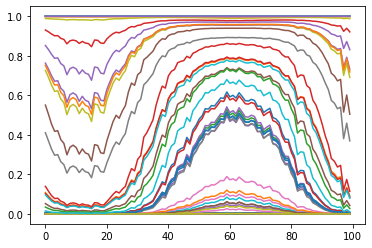

In [121]:
for i in range(l21H.shape[1]):
    plt.plot(l21H[:,i], label = "L val")



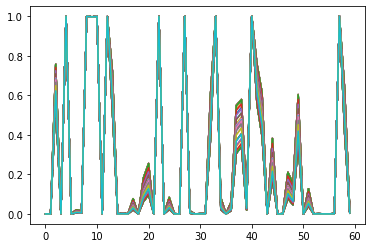

In [103]:
for i in range(l21H.shape[0]):
    plt.plot(l21H[i,:], label = "L val")


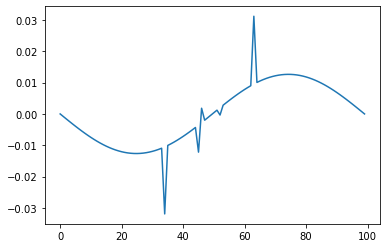

In [74]:
plt.plot(X[:,0])

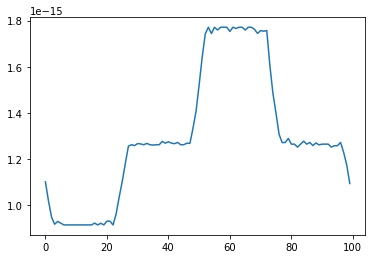

In [86]:
plt.plot(L[:,5])

In [17]:
l21H

array([[4.5331848e-08, 3.0224087e-06, 9.9999940e-01, ..., 1.0000000e+00,
        9.9999213e-01, 1.0000000e+00],
       [9.9999976e-01, 1.0000000e+00, 9.8435915e-01, ..., 9.9257880e-01,
        1.0000000e+00, 9.6701741e-01],
       [9.9999970e-01, 9.9999940e-01, 9.8849344e-01, ..., 9.9549580e-01,
        1.0000000e+00, 9.8032582e-01],
       ...,
       [1.0000000e+00, 1.0000000e+00, 7.9599619e-03, ..., 2.8147042e-02,
        1.0000000e+00, 1.1351913e-02],
       [9.9997908e-01, 1.0000000e+00, 9.0959579e-01, ..., 9.8448277e-01,
        1.0000000e+00, 9.5124382e-01],
       [9.9998736e-01, 9.9999923e-01, 9.8207891e-01, ..., 9.8204499e-01,
        9.9999964e-01, 9.4308692e-01]], dtype=float32)

In [14]:
L

array([[3.4916950e-26, 1.5794357e-26, 1.3559557e-07, ..., 1.4736749e-17,
        2.2704396e-14, 3.1814958e-17],
       [9.9301871e-35, 0.0000000e+00, 3.5508408e-24, ..., 2.6828584e-27,
        2.0854181e-24, 0.0000000e+00],
       [1.6354686e-35, 0.0000000e+00, 2.7868318e-24, ..., 1.3729280e-27,
        9.6018325e-25, 0.0000000e+00],
       ...,
       [5.1893990e-15, 6.0555352e-21, 1.0936715e-19, ..., 1.4072059e-15,
        1.0339415e-12, 2.5978230e-30],
       [1.4728857e-35, 0.0000000e+00, 2.3754432e-24, ..., 1.6495478e-27,
        1.3072086e-24, 0.0000000e+00],
       [1.7970470e-35, 0.0000000e+00, 2.1956941e-24, ..., 1.7849070e-27,
        1.8456267e-24, 0.0000000e+00]], dtype=float32)

In [15]:
S

matrix([[-0.40164423, -0.11998487, -0.20696882, ..., -0.24139453,
         -0.3217942 , -0.21914448],
        [-0.40430806, -0.19577946, -0.10214359, ..., -0.217587  ,
         -0.33314796, -0.17390105],
        [-0.39981699, -0.09300494, -0.15369448, ..., -0.18091456,
          1.63036959, -0.26589823],
        ...,
        [ 1.43616482, -0.15203798, -0.20749758, ..., -0.23861517,
          1.63036959, -0.25785576],
        [-0.38958276,  0.        , -0.20683139, ..., -0.17745348,
         -0.28322888, -0.25721141],
        [-0.36601815, -0.03578073, -0.14989704, ..., -0.19319542,
         -0.30031159, -0.31458025]])

In [ ]:
# current largest potential problem is that it trains the entire matrix as one data point
# that works fine for images, who are legit matrices, 

In [174]:
# training stops improving.. is LR too low or too high?
# also, what are the dims at each point, is this algo taking the entire matrix at once? 

In [68]:
pd.DataFrame(np.around(x, 1)[0:5])
pd.DataFrame(np.around(L, 1)[0:5])
pd.DataFrame(np.around(S, 1)[0:5])

,0,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,79,80
0,0.0,0.0,0.0,0.0,0.0,0.0,0.7,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.7,...,0.0,0.7,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.7,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.7,0.0,0.0,0.7,0.0,0.0,0.0,0.5,0.0
3,0.7,0.0,0.0,0.0,0.0,0.0,0.7,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.7,0.5,0.0,0.7,0.0,0.0
4,0.0,0.0,0.0,0.7,0.0,0.0,0.7,0.0,0.0,0.7,...,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
L

array([[0.1567479 , 0.30905938, 0.52031744, ..., 0.13211042, 0.37644204,
        0.5822023 ],
       [0.15674827, 0.30906016, 0.5203181 , ..., 0.1321108 , 0.37644285,
        0.58220315],
       [0.15674832, 0.30906016, 0.52031815, ..., 0.13211086, 0.3764429 ,
        0.58220315],
       ...,
       [0.15674838, 0.30906022, 0.52031815, ..., 0.1321109 , 0.37644297,
        0.5822032 ],
       [0.15674832, 0.30906016, 0.52031815, ..., 0.13211086, 0.3764429 ,
        0.58220315],
       [0.15674838, 0.30906016, 0.52031815, ..., 0.1321109 , 0.37644294,
        0.58220315]], dtype=float32)

In [65]:
pd.DataFrame(np.around(L,1))
help(np.around)

Help on function around in module numpy:

around(a, decimals=0, out=None)
    Evenly round to the given number of decimals.
    
    Parameters
    ----------
    a : array_like
        Input data.
    decimals : int, optional
        Number of decimal places to round to (default: 0).  If
        decimals is negative, it specifies the number of positions to
        the left of the decimal point.
    out : ndarray, optional
        Alternative output array in which to place the result. It must have
        the same shape as the expected output, but the type of the output
        values will be cast if necessary. See `ufuncs-output-type` for more
        details.
    
    Returns
    -------
    rounded_array : ndarray
        An array of the same type as `a`, containing the rounded values.
        Unless `out` was specified, a new array is created.  A reference to
        the result is returned.
    
        The real and imaginary parts of complex numbers are rounded
        separately.

In [133]:
pd.DataFrame(np.around(S, 2))

,0,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,79,80
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [153]:
import statistics
import seaborn

D:\programs\Anaconda\envs\tensorflow2\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\programs\Anaconda\envs\tensorflow2\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


<AxesSubplot:ylabel='Density'>

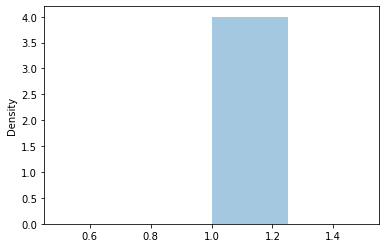

In [176]:
L.shape

all = []
for i in range(0, L.shape[1]):
    all.append(statistics.mean(L[:, i]))

all = np.array(all)
sns.distplot(all)

In [177]:
L.shape[1]

20

In [178]:
S

matrix([[0.        , 0.        , 0.10046257, ..., 0.        , 0.23688205,
         4.18666963],
        [0.        , 0.        , 0.29246966, ..., 0.        , 0.13860606,
         4.35147569],
        [0.        , 0.        , 0.07200625, ..., 0.        , 0.30945149,
         4.08131912],
        ...,
        [0.        , 0.        , 0.1205154 , ..., 0.        , 0.28861502,
         4.2299734 ],
        [0.        , 0.        , 0.2383594 , ..., 0.        , 0.38603865,
         4.19121101],
        [0.        , 0.        , 0.13528742, ..., 0.        , 0.24790533,
         4.28617866]])

In [ ]:
# So the challenge is that L is not as expected. L approaches 1 for all values, when it should distinguish 1, 5, 9, 13.. 
# try different tuning parameters for lambda: 
### doesn't change anything. 

# try changing the training of the DAE
#### training of 1 row per pred produced l = 0.98 whereas training of entire matrix produced L values of exactly 1.0

# try alternate autoencoders: 
###


# lambda is the parameter that tunes sparcity, so if I'm not able to get the balance between L and S that I expect, 
# I likely need to adjust lambda... however, adjustments to lambda have failed to produce the expected results thus far. 
# (Even extreme values of labmda)

# how do we know what a 'good' lambda is? 


#### the L2 norm may be the problem as L2 norm aims to reduce noise across the.... not sure where I was going with this. 


# note
# L represents the part of the input data that is well represented by the hidden layer of the autoencoder

[0.001, 0.001, 0.8678, 0.8678, 0.001, 0.001, 0.8678, 0.001, 0.8678, 0.001, 0.8678, 0.001, 0.8678, 0.8678, 0.001, 0.001, 0.8678, 0.001, 0.8678, 0.8678, 0.001, 0.001, 0.8678, 0.8678, 0.001, 0.001, 0.8678, 0.8678, 0.001, 0.001, 0.8678, 0.001, 0.8678, 0.001, 0.8678, 0.001, 0.8678, 0.8678, 0.001, 0.001, 0.8678, 0.001, 0.8678, 0.8678, 0.001, 0.001, 0.8678, 0.001, 0.001, 0.8678, 0.8678, 0.001, 0.001, 0.8678, 0.001, 0.8678, 0.001, 0.8678, 0.001, 0.8678, 0.8678, 0.001, 0.001, 0.8678, 0.001, 0.8678, 0.8678, 0.001, 0.001, 0.8678, 0.8678, 0.001, 0.001, 0.8678, 0.8678, 0.001, 0.001, 0.8678, 0.001, 0.8678, 0.001, 0.8678, 0.001, 0.8678, 0.8678, 0.001, 0.001, 0.8678, 0.001, 0.8678, 0.8678, 0.001, 0.001, 0.8678, 0.001, 0.001, 0.8678, 0.8678, 0.001, 0.001, 0.8678, 0.001, 0.8678, 0.001, 0.8678, 0.001, 0.8678, 0.8678, 0.001, 0.001, 0.8678, 0.001, 0.8678, 0.8678, 0.001, 0.001, 0.8678, 0.8678, 0.001, 0.001, 0.8678, 0.8678, 0.001, 0.001, 0.8678, 0.001, 0.8678, 0.001, 0.8678, 0.001, 0.8678, 0.8678, 0.001, 0.0

D:\programs\Anaconda\envs\tf1\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\programs\Anaconda\envs\tf1\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


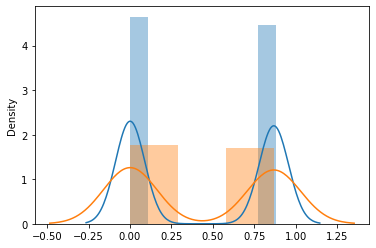

In [16]:
L.shape

l = np.array(L).flatten()

sns.distplot(l) #### NO! should be 4 or 5 points (not 2, maybe was over-fitting)

# may be plotting two columns due to bin size? Probably not, but maybe. Should define a different way to sum and 
# measure the rows. I.e. average each row and plot the averages

z = []
for i in range(L.shape[0]):
    avg = sum(L[i])/len(L[i])
    z.append(round(avg, 4))

print(z)

z = np.array(z)

print("Length Z", z.shape)

sns.distplot(np.array(z).flatten())

print("set Z", set(z))

In [25]:
if __name__ == "__main__":

    LL = []
    SS = []
    for idx,val in numb.iterrows():
        x = np.matrix(numb.iloc[idx,:])
        #print(x.shape)

        with tf.Session() as sess:
            rae = RobustL21Autoencoder(sess = sess, lambda_= 0.1, layers_sizes=[20, 10, 5, 3]) # [784,400,255,100]
            L, S = rae.fit(x, sess = sess, inner_iteration = 5, iteration = 4,verbose = False) 
            LL.append(L)
            SS.append(S)

X size: 20
X shape: (1, 20)


NameError: name 'shrink' is not defined

In [18]:
### try new code with tf2
rae = RobustL21Autoencoder(lambda_= 0.1, layers_sizes=[20, 10, 5, 3]) # [784,400,255,100] # sess = sess, 

L, S = rae.fit(x, inner_iteration = 5, iteration = 4,verbose = False) 
#LL.append(L)
#SS.append(S)


NameError: name 'RobustL21Autoencoder' is not defined

## L - the 'non-linear manifold' is ALWAYS the SAME!!

### New workspace: try implementing the new Robust Autoencoder

In [101]:
import numpy as np
import numpy.linalg as nplin
import tensorflow as tf
from BasicAutoencoder import DeepAE as DAE
from shrink import l1shrink as SHR 

class RDAE(object):
    """
    @author: Chong Zhou
    2.0 version.
    complete: 10/17/2016
    version changes: move implementation from theano to tensorflow.
    3.0
    complete: 2/12/2018
    changes: delete unused parameter, move shrink function to other file
    update: 03/15/2019
        update to python3 
    Des:
        X = L + S
        L is a non-linearly low rank matrix and S is a sparse matrix.
        argmin ||L - Decoder(Encoder(L))|| + ||S||_1
        Use Alternating projection to train model
    """
    def __init__(self, sess, layers_sizes, lambda_=1.0, error = 1.0e-7, inputsize = (1,20)): # added input sizes
        """
        sess: a Tensorflow tf.Session object
        layers_sizes: a list that contain the deep ae layer sizes, including the input layer
        lambda_: tuning the weight of l1 penalty of S
        error: converge criterior for jump out training iteration
        """
        self.lambda_ = lambda_
        self.layers_sizes = layers_sizes
        self.error = error
        self.errors=[]
        self.AE = DAE.Deep_Autoencoder( sess = sess, input_dim_list = self.layers_sizes)

    def fit(self, X, sess, learning_rate=0.15, inner_iteration = 50,
            iteration=20, batch_size=1, verbose=False):
        
        
        ## The first layer must be the input layer, so they should have same sizes.
        assert X.shape[1] == self.layers_sizes[0]

        ## initialize L, S, mu(shrinkage operator)
        self.L = np.zeros(X.shape)
        self.S = np.zeros(X.shape)

        mu = (X.size) / (4.0 * nplin.norm(X,1))
        print ("shrink parameter:", self.lambda_ / mu)
        LS0 = self.L + self.S
        
        XFnorm = nplin.norm(X,'fro')
        if verbose:
            print ("X shape: ", X.shape)
            print ("L shape: ", self.L.shape)
            print ("S shape: ", self.S.shape)
            print ("mu: ", mu)
            print ("XFnorm: ", XFnorm)

        for it in range(iteration):
            if verbose:
                print ("Out iteration: " , it)
            ## alternating project, first project to L
            self.L = X - self.S
            ## Using L to train the auto-encoder
            self.AE.fit(X = self.L, sess = sess,
                                    iteration = inner_iteration,
                                    learning_rate = learning_rate,
                                    batch_size = batch_size,
                                    verbose = verbose)
            ## get optmized L
            self.L = self.AE.getRecon(X = self.L, sess = sess)
            
            ## alternating project, now project to S
            self.S = SHR.shrink(self.lambda_/mu, (X - self.L).reshape(X.size)).reshape(X.shape)
            
            ## break criterion 1: the L and S are close enough to X
            c1 = nplin.norm(X - self.L - self.S, 'fro') / XFnorm
            ## break criterion 2: there is no changes for L and S 
            c2 = np.min([mu,np.sqrt(mu)]) * nplin.norm(LS0 - self.L - self.S) / XFnorm

            if verbose:
                print ("c1: ", c1)
                print ("c2: ", c2)

            if c1 < self.error and c2 < self.error :
                print ("early break")
                break
            ## save L + S for c2 check in the next iteration
            LS0 = self.L + self.S
            
        return self.L , self.S
    
    def transform(self, X, sess):
        L = X - self.S
        return self.AE.transform(X = L, sess = sess)
    
    def getRecon(self, X, sess):
        return self.AE.getRecon(X, sess = sess)


In [102]:
if __name__ == "__main__":
    #x = np.load(r"../data/data.npk", allow_pickle = True)[:500]
    for idx,val in numb.iterrows():
        x = np.matrix(numb.iloc[idx,:])
        
        
        with tf.Session() as sess:
            rae = RDAE(sess = sess, lambda_= 0.1*x.shape[0], layers_sizes=[20, 10, 5, 3]) # [784,400,255,100]
            L, S = rae.fit(x, sess = sess, inner_iteration = 1, iteration = 4,verbose = True) 
            M_Transf=rae.transform(X=X,sess=sess)
            M_Recons = rae.getRecon(X = X, sess = sess) # added these last two... 

shrink parameter: 0.0702166003189276
X shape:  (1, 20)
L shape:  (1, 20)
S shape:  (1, 20)
mu:  1.4241646497522609
XFnorm:  5.688262550057416
Out iteration:  0
    iteration :  0 , cost :  249.575


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [72]:
# epsilon comparison is still messed up. Check if epsilon is an array or a single integer. 

for idx,val in numb.iterrows():
    yy = np.matrix(numb.iloc[idx,:])
    #print(yy.shape)
   

In [ ]:
# shrink is not working becaquse x is matrix rather than a vector. Need to feed data in one row at a time. 

# I need to ensure x is a vector! I think this is my fault it's not working. 

# check how HE trained images: 

def shrink(epsilon, x): 
    """
    @Original Author: Prof. Randy
    @Modified by: Chong Zhou
    update to python3: 03/15/2019
    Args:
        epsilon: the shrinkage parameter (either a scalar or a vector)
        x: the vector to shrink on

    Returns:
        The shrunk vector
    """
    output = np.array(x*0.)

    for idx, ele in enumerate(x):
        if ele > epsilon:
            output[idx] = ele - epsilon
        elif ele < -epsilon:
            output[idx] = ele + epsilon
        else:
            output[idx] = 0.
    return output




In [28]:
# can prob scrap this once I figure out how to feed a vector. 
epsilon = 1
for i in x:
    output = np.array(x*0.)
        
    for idx, ele in enumerate(i):
        print(idx)
        print(ele)
        if ele > epsilon:
            output[idx] = ele - epsilon
        elif ele < -epsilon:
            output[idx] = ele + epsilon
        else:
            output[idx] = 0.

            
            #return output
    
    

0
[[ 2.68908254  0.20377624 -0.65410784  0.76755269  2.53570324  0.97765769
   0.15350844 -0.15789158  1.58324769  4.09399943 -0.33717254  1.39267646
   1.50037684  0.14434595  2.86836397  0.86329883 -1.5124115   1.62483521
   1.44079755  1.36877674]]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

# Notes as of 6.9.2020:
I've been playing around with my 'numbers' data set, working to train the robust deep autoencoder. 
This should be a pretty simple task, I expect the algorithm to predict the groups of data pretty well (1, 5, 9, and 13). There is one occurrence of 30 which I expect to be detected as an outlier. 

What is happening is that as the network trains, L converges towards some mean value and S ends up capturing the meaningful differences between groups. To me, this process represents overfitting. I have been trying to get cost down as close to zero as possible, but maybe that's the issue. Low cost indicates potential over-fitting. 

Lambda is the parameter of importance for the S matrix. When lambda is small, the shrinkage function is given little weight.
Setting labmda to 1 actually seems to prevent overfitting. When lambda is set to0 low, S will be completely sparse.

As the cost decreases, the unique groups within x become similar. -- actually not true
As the minimum layer size (size of the decoder input) gets smaller, the range of unique values generated in the output tends to decrease. So this is basically saying that as we give the network less flexibility (range) to express itself, its is forced to express itself more concisely. It makes better use of the low-dimensional values, where a slight change in an embedding value yields a completely different classification. All of this makes sense. 

However, when the cost is minimized, in some cases... the autoencoder starts to yield L values that are exactly the same (even among classes) and S is left containing the differences between the data points. In some sense it makes sense that this would happen, but it also strikes me that this is overfitting. L should produce clear, denoised components. 

Right now I can't tell whether a given data point is 'denoised' because I don't have noisy data points, I only have one outlier. So going forward, I should use the random function to add a bit of noise to each element, in each row in the data set. 
Then I can see if the true values are recoverable. If so, it's working. If not, need to re-evaluate. 

Then, I need to learn how to feed data into the model to get the encoded values for each data point. Doing that, I can then cluster the data points into it's natural groupings and make sure that the process works. After that, I am ready to try it on the yeast data. 

### Update as of 6.14.2020:

I'm still working to discover why the function isn't recovering the data in L. It could be that the problem is I am optimizing across the entire matrix when I need to focus on optimizing across a single vector at a time. I'm not exactly sure how to do that yet. I've tried using a batch size of one, but expected values are not returned. I think even with batch size of one the enitre matrix is optimized across the function. 

In [ ]:
# Adversarial Deconfounding Autoencoder for Learning Robust Gene Expression Embeddings

In [26]:
[(i) for i in L]

NameError: name 'mean' is not defined

Seaborn histograms indicate that S is capturing most of the distinguishing features of the values and L is capturing 

In [ ]:
if __name__ == "__main__":
    #x = np.load(r"../data/data.npk", allow_pickle = True)[:500]
    x = np.matrix(numbers)
    
    with tf.Session() as sess:
        #rae = RobustL21Autoencoder(sess = sess, lambda_=0.000015, layers_sizes=[17, 12, 8, 1]) # [784,400,255,100]
        rae = RobustL21Autoencoder(sess = sess, lambda_=200, layers_sizes=[20, 12]) # [784,400,255,100]
        # 17, 12, 10, 8

        #rae = RDAE(sess = sess, lambda_=0.015, layers_sizes=[17, 12, 8, 1])
        
        L, S = rae.fit(x, sess = sess, inner_iteration = 60, iteration = 5,verbose = True) 

In [196]:
k = [round(i.sum(),3) for i in L]
set(k)

{20.0}

### Save Yeung Code

In [ ]:
# Read in the data
yeung = pd.read_csv("D:\projects\korkin\yeung_raw_cellcycle_384_17.txt", sep = "\t", low_memory = False)

In [ ]:
# Trim df white spaces
def trim_all_columns(df):
    """
    Trim whitespace from ends of each value across all series in dataframe
    """
    trim_strings = lambda x: x.strip() if isinstance(x, str) else x
    return df.applymap(trim_strings)

yeung = trim_all_columns(yeung)

# Rename columns
yeung = yeung.rename(columns = {'Unnamed: 0': 'orf', 'Main Gp': 'phase'})

# Convert phase column to string
yeung['phase'] = yeung.phase.astype(str)

# Trim whitespace (if they exist) from column names
yeung.rename(columns=lambda x: x.strip(), inplace=True)

In [ ]:
# all time point columns as int type
for column in yeung.columns:
    if yeung[column].dtype == 'int64':
        # set column name as 'x'
        x = yeung[column]
        
        # subtract the mean of x from each value of x
        x -= np.mean(x)
        
        # divide each value in the array by the standard deviation of the array
        x /= np.std(x)
        
        # replace prior values with z-score values
        yeung[column] = x
yeung = yeung.iloc[:,2:20]

In [ ]:
if __name__ == "__main__":
    #x = np.load(r"../data/data.npk", allow_pickle = True)[:500]
    x = np.matrix(yeung)
    
    with tf.Session() as sess:
        #rae = RobustL21Autoencoder(sess = sess, lambda_=0.000015, layers_sizes=[17, 12, 8, 1]) # [784,400,255,100]
        rae = RobustL21Autoencoder(sess = sess, lambda_=1, layers_sizes=[17, 12, 8, 3]) # [784,400,255,100]
        # 17, 12, 10, 8
        #rae = RDAE(sess = sess, lambda_=0.015, layers_sizes=[17, 12, 8, 1])
        
        L, S = rae.fit(x, sess = sess, inner_iteration = 20, iteration = 5,verbose = True) 

# Find epsilon in his work, does he define it as an array? If so, may fix my problem!

# Try clustering L

In [ ]:
# see if natural clusters are detected. If so, may be working correctly. If not, can't trust it. 


#### Test out RobustDeepAutoencoder

In [101]:
if __name__ == "__main__":
    
    # = np.load(r"../data/data.npk")[:500]
    with tf.Session() as sess:
        
        x = np.matrix(numbers)
         
        rae = RDAE(sess = sess, lambda_= 2000, layers_sizes=[20, 14, 8])

        L, S = rae.fit(x ,sess = sess, learning_rate=0.01, batch_size = 40, inner_iteration = 50, \
                iteration=1, verbose=True)


shrink parameter: 238.91048326357938
X shape:  (20, 20)
L shape:  (20, 20)
S shape:  (20, 20)
mu:  8.371336295835492
XFnorm:  20.0
Out iteration:  0
    iteration :  0 , cost :  255.39145
    iteration :  20 , cost :  246.89925
    iteration :  40 , cost :  239.32169


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
### notes as of 6/8/2020
The RobustAutoencoder is not working properly. This is likely because of the l1shrink function (RAE uses l21shrink).
l1shrink is currently failing because it utilizes enumerate() to process the function but we are feeding a matrix to l1shrink
and enumerate doesn't return elementwise pieces it returns the whole matrix. So I need to rewrite this function so that it works.


In [ ]:
        #recon_rae = rae.getRecon(x, sess = sess)

        #print ("cost errors, not used for now:", rae.errors)
    #from collections import Counter
    #print ("number of zero values in S:", Counter(S.reshape(S.size))[0])

#### test out with my pseudo data set 

In [ ]:
# now what do we do with matrix L and S? 
# Use L for clustering? 

In [102]:
x = np.matrix(data)
x.shape

(384, 17)

In [126]:
# Original code: 

sess=tf.Session() # create session, sess.run() function then evaluates the tensor and returns the results.

#print('run(tf_t) : \n', sess.run(tf_t))

with sess.as_default():
# args: self, sess, layers_sizes, lambda_=1.0, error = 1.0e-5
    
    # x = np.array(data.iloc[0,:])
    autoencoder = RobustL21Autoencoder(sess = sess, layers_sizes = [20, 16, 8, 4])
    L, S = autoencoder.fit(x, sess= sess, verbose = True)
    
sess.close()#close session

NameError: name 'tf_t' is not defined

In [53]:
sess

In [45]:
tf.global_variables_initializer().run()

ValueError: Cannot execute operation using `run()`: No default session is registered. Use `with sess.as_default():` or pass an explicit session to `run(session=sess)`

In [144]:
def shrink(epsilon, x):
    """
    @Original Author: Prof. Randy
    @Modified by: Chong Zhou
    update to python3: 03/15/2019
    Args:
        epsilon: the shrinkage parameter (either a scalar or a vector)
        x: the vector to shrink on

    Returns:
        The shrunk vector
    """
    output = np.array(x*0.)

    for idx, ele in enumerate(x):
        if ele > epsilon:
            output[idx] = ele - epsilon
        elif ele < -epsilon:
            output[idx] = ele + epsilon
        else:
            output[idx] = 0.
    return output

In [32]:
    with tf.Graph().as_default():
        with tf.Session() as sess:
            rael21 = l21RDAE.RobustL21Autoencoder(sess = sess, lambda_= lamda*X.shape[0], layers_sizes=layers)
            l21L, l21S = rael21.fit(X = X, sess = sess, inner_iteration = inner, \
                            iteration = outer, batch_size = batch_size, learning_rate = learning_rate,  verbose = True)

<function __main__.<lambda>()>

In [60]:
# example code
layers = [10, 5, 10]

with tf.Graph().as_default():
    with tf.Session() as sess:
        tf_t=tf.convert_to_tensor(data,dtype=tf.float64)
        rael21 = RobustL21Autoencoder(tf_t,  layers_sizes=layers)

AttributeError: 'Tensor' object has no attribute 'run'

In [ ]:
# Tensorflow needs graph and Session to compute. 
# The first step of the startup graph is to create a Session object. 
# If there are no creation parameters, the Session builder will start the default graph.
# Session manages all resources of the TensorFlow program runtime. 
# The Session needs to be closed after all calculations are completed to help the system recycle resources, 
# otherwise the problem of resource leakage may occur.


In [2]:
#!pip install python-louvain
from community import community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx

# Louvain Algorithm

In [40]:
#scerv = pd.read_csv("C:\\Users\\user\\projects\\korkin\\RobustAutoencoder\\model\\SaccharomycesCerevisiaeS288C_htb_hq.txt", \
                   sep = '\t', low_memory = False)
#scerv

IndentationError: unexpected indent (<ipython-input-40-ff2856ab447d>, line 2)

In [41]:
# Read in and try evaluating the binary data
scerv = pd.read_csv("C:\\Users\\user\\projects\\korkin\\RobustAutoencoder\\model\\SaccharomycesCerevisiaeS288C_binary_hq.txt",
                   sep = '\t', low_memory = False)
scerv

,Uniprot_A,Uniprot_B,Gene_A,Gene_B,ORF_A,ORF_B,Alias_A,Alias_B,pmid:method:quality
0,A0A023PYF7,P39743,A0A023PYF7,RVS167,NaN,D9509.8,S000028763,S000002796,19841731:0398:HT
1,A0A250W8A7,A0A250W8A7,YSP2,YSP2,SCKG_0199,SCKG_0199,NaN,NaN,29467216:0114:LC
2,A0A250WL92,A0A250WL92,LAM4,LAM4,SCKG_4597,SCKG_4597,NaN,NaN,29463678:0114:LC
3,A2P2R3,P04821,A2P2R3,CDC25,NaN,L2142.6,S000004689,S000004301,19841731:0018:HT
4,A2P2R3,P38753,A2P2R3,HSE1,NaN,NaN,S000004689,S000000994,19841731:0018:HT
...,...,...,...,...,...,...,...,...,...
23197,Q99312,Q99312,ISN1,ISN1,O3548,O3548,S000005681,S000005681,11283351:0018:HT|11283351:0399:HT|11283351:039...
23198,Q99315,Q99315,TY3B-G,TY3B-G,G5984,G5984,S000007347,S000007347,24608367:0114:LC
23199,Q99380,Q99380,OST4,OST4,NaN,NaN,S000002391,S000002391,16096345:0090:LC|16754853:0007:LC
23200,Q99385,Q99385,VCX1,VCX1,NaN,NaN,S000002286,S000002286,23685453:0114:LC


In [22]:
# read in and evaluate hihgh-throughput co-complex data
#scerv = pd.read_csv("C:\\Users\\user\\projects\\korkin\\RobustAutoencoder\\model\\SaccharomycesCerevisiaeS288C_htc_hq.txt",\
                   low_memory = False, sep = '\t')
#scerv

,Uniprot_A,Uniprot_B,Gene_A,Gene_B,ORF_A,ORF_B,Alias_A,Alias_B,pmid:method:quality
0,A0A023PXH6,P10592,A0A023PXH6,SSA2,NaN,L0931,S000004782,S000003947,19536198:0676:HT
1,A0A023PXI0,P11484,A0A023PXI0,SSB1,NaN,NaN,S000004922,S000002388,19536198:0676:HT
2,A0A023PZ99,P10591,A0A023PZ99,SSA1,NaN,NaN,S000002415,S000000004,19536198:0676:HT
3,A0A023PZA9,P25491,A0A023PZA9,YDJ1,NaN,N2418|YNL2418C,S000002638,S000005008,19536198:0676:HT
4,A0A023PZE6,P39102,A0A023PZE6,XDJ1,NaN,L9449.3,S000002455,S000004080,19536198:0676:HT
...,...,...,...,...,...,...,...,...,...
64605,Q99207,Q99207,NOP14,NOP14,D1566,D1566,S000002307,S000002307,12150911:0004:HT
64606,Q99258,Q99258,RIB3,RIB3,D8035.30,D8035.30,S000002895,S000002895,11805826:0676:HT|11805826:0007:HT
64607,Q99287,Q99287,SEY1,SEY1,O3590,O3590,S000005691,S000005691,22940862:0004:HT
64608,Q99321,Q99321,DDP1,DDP1,O3575,O3575,S000005689,S000005689,22940862:0004:HT


In [4]:
scerv = scerv.loc[:,['Gene_A', 'Gene_B']]
print(len(scerv)) # 19085

19084


In [42]:
scerv = scerv.loc[:,['Uniprot_A', 'Uniprot_B']]
print(len(scerv)) # 19085

23202


In [271]:
#scerv = scerv.loc[:,['Uniprot_A', 'Uniprot_B']]
# Determine how many genes in the data set
#len(set(scerv['Uniprot_A'].values.tolist() + scerv['Uniprot_B'].values.tolist()))

In [33]:
# Determine how many genes in the data set
len(set(scerv['Gene_A'].values.tolist() + scerv['Gene_B'].values.tolist())) # 5030 unique genes. # Korkin found 5,687 genes

KeyError: 'Gene_A'

# LEFTOFF HERE

In [ ]:
# Number of communities being produced in my work does not equal that of the paper.  Possible reasons could be that I am using the woring data, 
# that I am creating the graph using the improper method, that I am running the louvain algorithm improperly. 

# I think I have the louvain algo running properly, doesn't seem easy to mess up. 
# I think what's most likely is that I'm creating the graph improperly.... that's the best place to start. 

# Using nx.from_pandas_edgelist seemed to work!!!! It's not perfect but I have 93 communities now. 

In [ ]:
# trying high-throughput co-complexe data --> only produce 16 or 19 communities... kinda weird. Doesn't 
# seem to be the appropriate set. Will have to examine in more detail later. 
# model genes or proteins? Makes sense to use genes since we're trying to model expression profiles

In [25]:
# from_pandas_edgelist(df, source='source', target='target', edge_attr=None, create_using=None)[source]

G = nx.from_pandas_edgelist(scerv, source = 'Gene_A', target = 'Gene_B')
G

KeyError: 'Gene_A'

In [43]:
# try protein protein interaction network instead
G = nx.from_pandas_edgelist(scerv, source = 'Uniprot_A', target = 'Uniprot_B')

In [44]:
# Create graph and partition
partition = community_louvain.best_partition(G)

# Resource on different networkx plots: https://networkx.github.io/documentation/stable/auto_examples/drawing/plot_edge_colormap.html#sphx-glr-auto-examples-drawing-plot-edge-colormap-py

In [45]:
partition

{'A0A023PYF7': 0,
 'P39743': 0,
 'A0A250W8A7': 1,
 'A0A250WL92': 2,
 'A2P2R3': 0,
 'P04821': 0,
 'P38753': 0,
 'D6VPM8': 3,
 'P38723': 4,
 'Q12328': 3,
 'D6VTK4': 3,
 'P08539': 5,
 'P18851': 6,
 'P32435': 3,
 'P32793': 0,
 'P32844': 3,
 'P53285': 3,
 'Q08646': 3,
 'Q08929': 4,
 'D6W196': 7,
 'P29704': 7,
 'P53983': 4,
 'E9P8D2': 8,
 'O13297': 9,
 'P04050': 9,
 'Q01159': 9,
 'O13329': 0,
 'P06700': 10,
 'P06843': 11,
 'P17123': 0,
 'P22216': 12,
 'P32605': 13,
 'P32902': 6,
 'P38633': 13,
 'P38987': 5,
 'P40089': 14,
 'P47035': 9,
 'Q00916': 0,
 'Q02208': 15,
 'Q03776': 0,
 'Q12072': 0,
 'Q12457': 6,
 'O13512': 14,
 'O13567': 14,
 'O13517': 16,
 'P40971': 16,
 'O13518': 17,
 'P32841': 17,
 'O13519': 3,
 'P19657': 3,
 'P38260': 3,
 'O13525': 10,
 'P27680': 10,
 'Q05779': 10,
 'O13527': 14,
 'P53550': 14,
 'O13530': 5,
 'P21825': 4,
 'P39534': 5,
 'O13531': 18,
 'P39940': 18,
 'P40568': 6,
 'P43582': 18,
 'Q02574': 13,
 'Q06525': 18,
 'O13532': 6,
 'P47128': 6,
 'O13535': 0,
 'P36006': 0,

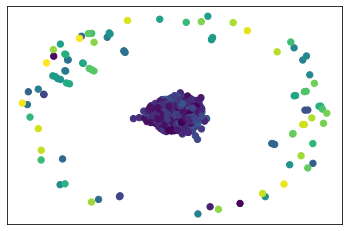

In [38]:
# draw the graph
pos = nx.spring_layout(G) # spring_layout
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)

nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))

nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

In [49]:
max(set(partition.values())) # partitioned into 9 communities.... why? 
#len(partition.keys())

94

In [66]:
partition.values()

# how to plot the frequency of values...

AttributeError: 'Graph' object has no attribute 'values'

In [50]:
# Generate dendrogram
dendroG = community_louvain.generate_dendrogram(G, part_init = partition)# , part_init = partition
dendroG

[{'A0A023PYF7': 0,
  'P39743': 0,
  'A0A250W8A7': 1,
  'A0A250WL92': 2,
  'A2P2R3': 0,
  'P04821': 0,
  'P38753': 0,
  'D6VPM8': 3,
  'P38723': 4,
  'Q12328': 3,
  'D6VTK4': 3,
  'P08539': 5,
  'P18851': 6,
  'P32435': 3,
  'P32793': 0,
  'P32844': 3,
  'P53285': 3,
  'Q08646': 3,
  'Q08929': 4,
  'D6W196': 7,
  'P29704': 7,
  'P53983': 4,
  'E9P8D2': 8,
  'O13297': 9,
  'P04050': 9,
  'Q01159': 9,
  'O13329': 0,
  'P06700': 10,
  'P06843': 11,
  'P17123': 0,
  'P22216': 12,
  'P32605': 13,
  'P32902': 6,
  'P38633': 13,
  'P38987': 5,
  'P40089': 14,
  'P47035': 9,
  'Q00916': 0,
  'Q02208': 0,
  'Q03776': 0,
  'Q12072': 0,
  'Q12457': 11,
  'O13512': 14,
  'O13567': 14,
  'O13517': 15,
  'P40971': 15,
  'O13518': 16,
  'P32841': 16,
  'O13519': 3,
  'P19657': 3,
  'P38260': 3,
  'O13525': 10,
  'P27680': 10,
  'Q05779': 10,
  'O13527': 14,
  'P53550': 14,
  'O13530': 5,
  'P21825': 4,
  'P39534': 5,
  'O13531': 17,
  'P39940': 17,
  'P40568': 6,
  'P43582': 17,
  'Q02574': 13,
  'Q06

In [58]:
for level in range(len(dendroG) - 1) :
    if level != 0:
        print("partition at level", level,
        "is", community_louvain.partition_at_level(dendroG, level))

In [52]:
community_louvain.modularity(partition, G) # modularity: 0.576

0.578502624558621

In [ ]:
# Korkin said they found 81 communities
# How do we determine the number of communities discovered by Louvain Algo?

In [53]:
g = community_louvain.induced_graph(partition, G)
g
#dendroG = community_louvain.generate_dendrogram(g, part_init = partition)

In [67]:
partition = community_louvain.best_partition(g)
partition.values()

dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94])

In [ ]:
### dev, keeping for notes but replaceing with version from git as this is not running as expected. 
class RobustL21Autoencoder():
    """
    @author: Chong Zhou
    first version.
    complete: 10/20/2016
    Update to Python3: 03/15/2019
    Des:
        X = L + S
        L is a non-linearly low dimension matrix and S is a sparse matrix.
        argmin ||L - Decoder(Encoder(L))|| + ||S||_2,1
        Use Alternating projection to train model
        The idea of shrink the l21 norm comes from the wiki 'Regularization' link: {
            https://en.wikipedia.org/wiki/Regularization_(mathematics)
        }
    Improve:
        1. fix the 0-cost bugs
    """
    # take self and it's parameters to initialize a deep autoencoder with session, input dim list, and self layers sizes
    def __init__(self, sess, layers_sizes, lambda_=1.0, error = 1.0e-5):
        self.lambda_ = lambda_
        self.layers_sizes = layers_sizes
        self.error = error
        self.errors=[]
        self.AE = DAE.Deep_Autoencoder(sess = sess, input_dim_list = self.layers_sizes)

    # take the initialized NN and input matrix X (as well as LR, inner iter, iter, batch size, and verbose params)
    def fit(self, X, sess, learning_rate=0.15, inner_iteration = 50,
            iteration= 3, batch_size=6, verbose=True):
        # iters = 20, batch size: 40
        
        ## The first layer must be the input layer, so they should have same sizes.
        assert X.shape[1] == self.layers_sizes[0]
        
        ## initialize L, S, as empty vectors
        ## and mu(shrinkage operator)??? initialized mu? 
        self.L = np.zeros(X.shape)
        self.S = np.zeros(X.shape)
         
        ## To estimate the size of input X
        if verbose:
            print ("X shape: ", X.shape)
            print ("L shape: ", self.L.shape)
            print ("S shape: ", self.S.shape)
            
        # For each (outer) iteration, print out the iteration number
        for it in range(iteration):
            if verbose:
                print ("Out iteration: " , it)
            
            ## alternating project, first project to L
            self.L = X - self.S
            
            ## Using L to train the auto-encoder
            self.AE.fit(self.L, sess = sess,
                                    iteration = inner_iteration,
                                    learning_rate = learning_rate,
                                    batch_size = batch_size,
                                    verbose = verbose)
            ## get optmized L
            ## what's this doing? ...
            self.L = self.AE.getRecon(X = self.L, sess = sess)
            
            ## alternating project, now project to S and shrink S
            #self.S = SHR.l21shrink(self.lambda_, (X - self.L)) # changed from l21 to l1
            # what is the shrink function doing
            
            # take self.shrink, X-L, reshaped.... 
            # shrink (below) takes x and shrinkage parameter epsilon (a scalar or vector) and returns a shrunk vector
            # so in this case, the input is self.shrink, and 'X' is actually 'S' (because X - L is S)
            # reshape is a numpy function that takes as arguments 'a' - an array to be reshaped, newshape, and order = 'C'
            ## ‘C’ means to read / write the elements using C-like index order, with the last axis index changing fastest, 
            ## back to the first axis index changing slowest.
            ### so S is reshaped to X.size, fed to the shrink function, and the shrunk vector is reshaped to X.shape
            ### so clearly the reshape is to allow for the flow of the x vactor amongst these functions, but isn't 
            ### the x-vector shape/size the same? Let's check it out
            print("X size:", X.size)
            print("X shape:", X.shape)
            self.S = RobustL21Autoencoder.shrink(shrink, (self.X - self.L).reshape(X.size,order='C')).reshape(X.shape,order='C')
            
        return self.L , self.S
    
    def transform(self, X, sess):
        L = X - self.S
        return self.AE.transform(X = L, sess = sess)
    def getRecon(self, X, sess):
        return self.AE.getRecon(X, sess = sess)
    
    def shrink(epsilon, x):
        """
        @Original Author: Prof. Randy
        @Modified by: Chong Zhou
        Args:
            epsilon: the shrinkage parameter (either a scalar or a vector)
            x: the vector to shrink on
        Returns:
            The shrunk vector
        """
        output = np.array(x*0.)

        for i in range(len(x)):
            if x[i] > epsilon:
                output[i] = x[i] - epsilon
            elif x[i] < -epsilon:
                output[i] = x[i] + epsilon
            else:
                output[i] = 0
        return output

    
# Model my code below after this section:    
#if __name__ == "__main__":
#    x = np.load(r"../data/data.npk", allow_pickle = True)[:500]
#    
#    with tf.Session() as sess:
#        rae = RobustL21Autoencoder(sess = sess, lambda_= 4000, layers_sizes=[784,400,255,100]) # [784,400,255,100]

#        L, S = rae.fit(x, sess = sess, inner_iteration = 60, iteration = 5,verbose = True) 